# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [2]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [3]:
#!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

#!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

In [4]:
#!unzip -qq images_background.zip
#!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [4]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names 
    
    for class_name in  os.listdir(alphabet_directory_path):
        for img in os.listdir(alphabet_directory_path  + class_name):
            datax.append(alphabet_directory_path + class_name + '/' + img)
            datay.append(alphabet_directory_path +  class_name)
    
    return np.array(datax), np.array(datay)

In [12]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = []
    datay = []
    
    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [16]:
trainx, trainy = read_images('images_background')

In [17]:
testx, testy = read_images('images_evaluation')

In [18]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((19280,), (19280,), (13180,), (13180,))

## Create samples

In [19]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])
        
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [20]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0)/255)

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

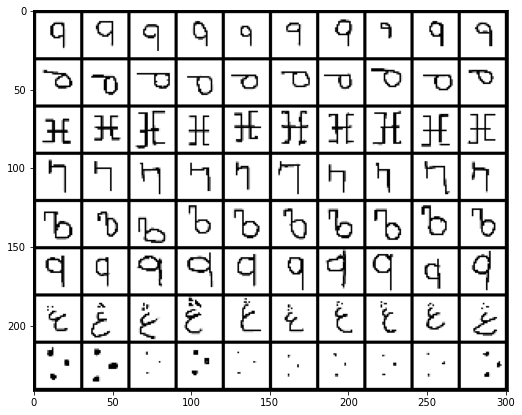

In [29]:
n_way = 8
n_support = 5
n_query = 5

sample_example = extract_sample(n_way, n_support, n_query, trainx, trainy)
display_sample(sample_example['images'])

In [24]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [30]:
class Encoder(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.f = nn.Flatten()

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.f(x)

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [42]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images'].cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        
        x_support = sample_images[:, :n_support]       
        x_query = sample_images[:, n_support:]
   
        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
        z = self.encoder.forward(x)
    
        z_dim = z.size(-1) 
        v = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        q = z[n_way*n_support:]

        v = v.unsqueeze(0).expand(n_way*n_query, n_way, z_dim)
        q = q.unsqueeze(1).expand(n_way*n_query, n_way, z_dim)
        dists = torch.pow(torch.pow(v - q, 2).sum(2), 0.5)
        soft = F.log_softmax(-dists, dim=1)
   
        true = torch.arange(0, n_way).view(n_way, 1).expand(n_way, n_query).flatten().cuda()
        
        loss_val = -soft.max(1)[0].view(-1).mean()
        acc_val = (soft.argmax(1).flatten() == true).sum()/len(true)
        
        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': soft.argmax(1).cpu().numpy()
            }

In [40]:
def load_protonet_conv(x_dim, hid_dim, z_dim):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Encoder(hid_dim)

    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [33]:
from torch.utils.tensorboard import SummaryWriter
import wandb


def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop
    wandb.init()
    
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0
        writer = SummaryWriter()
        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            writer.add_scalar('Loss/train', output['loss'], episode)
            writer.add_scalar('Acc/train', output['acc'], episode)
            
            
            loss.backward()
            optimizer.step()
            
            wandb.log({"acc": output['acc'], "loss": output['loss']})
    
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
    
        
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

In [72]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [73]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

acc,▄▅▄▃▄▄▃▃▃▄▁▆▃▁▃▂▃▅▆▅▃▃▂▃▆▄▅▆▆▄▆▃▆▅▆▅▅▇▆█
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.57667
loss,0.4902


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.4014 Acc: 0.7260
CPU times: total: 21.4 s
Wall time: 14.6 s


## Test

In [69]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [81]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 100

In [71]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/100 [00:00<?, ?it/s]

Test results -- Loss: 0.1064 Acc: 0.8424


## Test on specific example

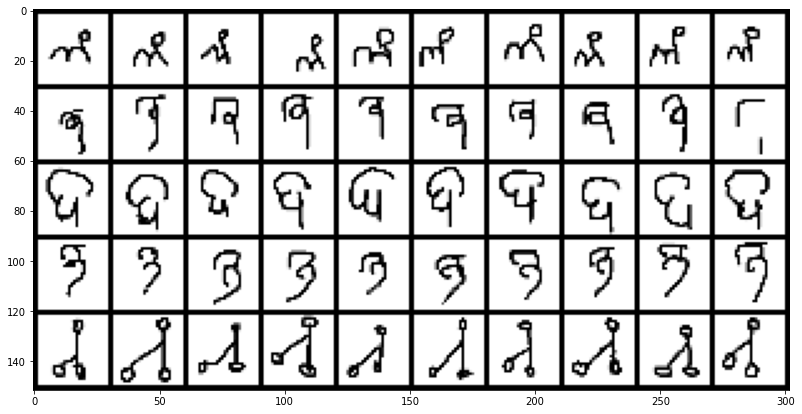

In [82]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [83]:
my_loss, my_output = model.set_forward_loss(my_sample)


In [84]:
my_output

{'loss': 0.233625590801239,
 'acc': 0.8399999737739563,
 'y_hat': array([1, 0, 4, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 4, 4,
        4, 4, 4], dtype=int64)}

In [78]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [79]:
def display_prediction(preds, sample):

    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']
    
    images = sample['images'][:, n_support:]/255
    fig, ax = plt.subplots(nrows=n_way, ncols=n_query,figsize=(10, 10), \
                            sharey=True, sharex=True)
    for idx, fig_x in enumerate(ax.flatten()):
        im_val, label = images[idx//n_way, idx%n_query], preds[idx]
        img_label = preds[idx]
        imshow(im_val.cpu(), \
              title=img_label,plt_ax=fig_x)

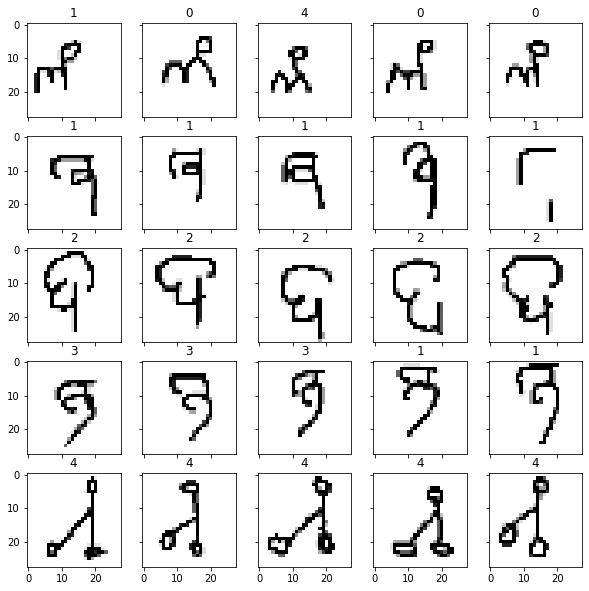

In [85]:
display_prediction(my_output['y_hat'], my_sample)